## Low Frequency Diffusion Analysis


This notebook summarzies analysis of the low frequency, Warburg-like impedance as of **5/10/2018**. The main goals are the following:

1) Find an appropriate functional form for $z_{d}$, the impedance of the Warburg element

2) Obtain parameter estimates for $z_{d}$

3) Relate these fit parameters to a physically meaningful picture.

Orazem [(10.1149/1.2168377)](http://jes.ecsdl.org/content/153/4/B129.abstract) suggests a particular functional form for $z_{d}$ based on ordinary diffusion through a finite layer. We will try to ammend this form using the anamolous diffusion considerations outlined by Bisquert [(10.1002/cphc.200390046)](https://onlinelibrary.wiley.com/doi/abs/10.1002/cphc.200390046).

We will first try and fit this functional form over an isolated frequency range. After observing these effects, we'll see if we can combine this with the high frequency blocking CPE analysis.

We begin by importing the data using the same block of code we used last time (again, note units).

In [1]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
%matplotlib inline


importdata = np.genfromtxt('IS400.csv',delimiter=',');  #read in data that i output from matlab. input format has each
                                                        #of the 16 Temperature data sets stacked vertically. 
npoints = 101; #each T has 101 points
IS400 = np.zeros((16,npoints,5)) #Initialize new 3d array to hold data. note: first index is what we would traditionally 
                            #think of as the last index. it makes sense though when you think hierarchically,
                            #i.e. main list has 16 elements each of which has 101 smaller elements containing 5 elemnts. 
for i in range(0,16):
    IS400[i,:,:]=importdata[(npoints*i):(npoints*(i+1)) , :] #slice the data into subarrays  
    
## Function definitions

def Zr(T): #pulls out Z' in units of kOhm*cm^{2} (these are the standard units of impedance). Note that as is, the data is already in units of kOhm
    return IS400[T,:,3]*4e-2
def Zi(T): #pulls out Z'' in units of kOhm*cm^{2}
    return IS400[T,:,4]*4e-2
def w(T): #pulls out omega
    return IS400[T,:,0]




Select and plot a range of the data to analyze. We care about the linear, low frequency part of the Nyquist plot. See what that range looks like in Im(Z) vs. $\omega$, as well.

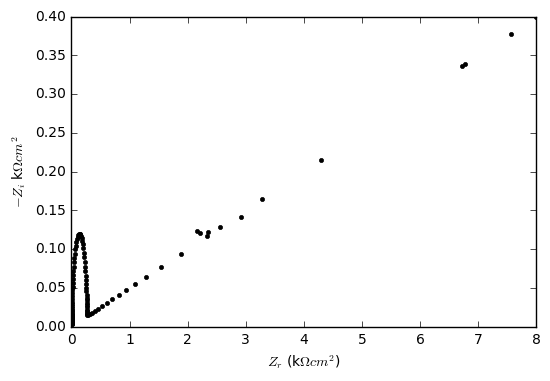

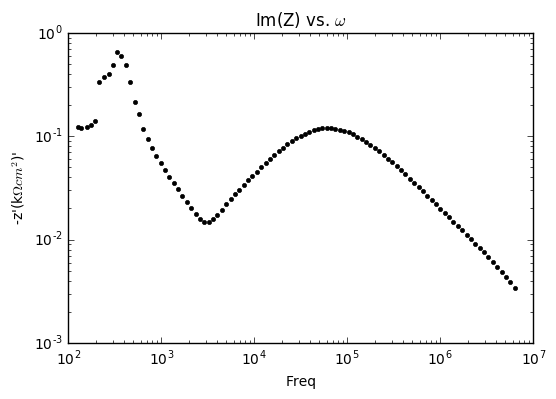

In [2]:
# Nyquist plot for the 13th curve.

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[:],-Zi(12)[:],'k.')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,8, 0,.4])
# plt.savefig('nyquistDiffKin.png')

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[:],abs(-Zi(12)[:]),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# plt.savefig('imZlog.png')

There's clearly some noise in the spectrum at low frequnecy end, giving rise to what looks like a peak. Let's see if we can bound the analysis on both the low and high frequency side. We want to consider **just** the decay part of Im(Z) vs $\omega$, above the sharp low frequency peak and below the parallel CPE broad peak in Im(Z) vs. $\omega$.

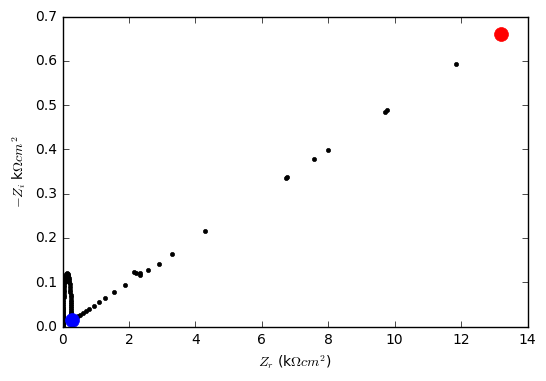

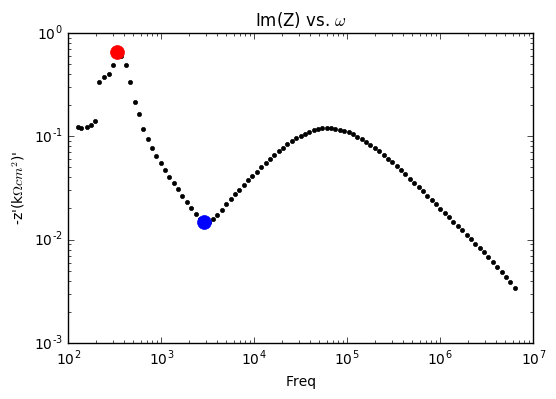

In [3]:
boundLF = np.argmax(abs(-Zi(12)))
boundHF = boundLF + 20



fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[:],-Zi(12)[:],'k.')
ax.plot(Zr(12)[boundLF],-Zi(12)[boundLF],'r.',markersize = 20)
ax.plot(Zr(12)[boundHF],-Zi(12)[boundHF],'b.',markersize = 20)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,12, 0,1])
# plt.savefig('nyquistDiffKin.png')

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[:],abs(-Zi(12)[:]),'k.')
ax.plot(w(12)[boundLF],abs(-Zi(12)[boundLF]),'r.',markersize = 20)
ax.plot(w(12)[boundHF],abs(-Zi(12)[boundHF]),'b.',markersize = 20)
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# plt.savefig('imZlog.png')

This is the range of data we will first analyze. According to Orazem, Warburg elements representing diffusion through a finite layer $z_{d}$ should have the following form:

$z_{d} = z_{0}\frac{ tanh((j\omega\tau_{d})^\frac{1}{2})}{(j\omega\tau_{d})^\frac{1}{2}}$

This assumes that the impedance has the familiar asymptotic form for ordinary diffusion: $z_{d} \propto (j\omega)^\frac{1}{2} $. This implies that the low frequency diffusion impedance should be at an angle of $\frac{\pi}{4}$ with respect to the real axis in the Nyquist plot. From above, we are *clearly* not in this regime, indicating anamolous diffusion. Without commenting too much on the physics of anamolous diffusion here (more on that later--right now let's worry about the data) the physics of anamolous diffusion match with my intutition about charge transport in these films. 

As pointed out by Bisquert, anomalous diffusion exhibits a $z_{d} \propto (j\omega)^{\frac{\beta}{2}}, 0<\beta <2 $. So let's fit the data range above to the following form:

$z_{d} = z_{0}\frac{ tanh((j\omega\tau_{d})^\beta)}{(j\omega\tau_{d})^\beta}, 0<\beta<1$

where we have re-named $\beta$ for simplicity. Based on futzing around witht this functional form in Wolfram Alpha, this should seems promising for fitting the low $\omega$ behavior in Im(Z) vs. $\omega$. So let's start with fits to this plot, then try the the simultaneous NLLS in the Nyqusit plot.  




In [4]:



w0 = w(12)[boundLF]

w0mat = w(12) - w0
print(w0)
print(w(12)[boundLF:boundHF])
print(w(12)[boundLF:boundHF]-w0)

# define trial fit to low freq data of Im(z) vs. w

def tFit1(w,zd0,td,b):
    
    return np.imag(zd0*(np.tanh((1j*(w)*td)**b)/((1j*(w)*td)**b)))

def tFit1Resid(params,w,Zi):
    parvals = params.valuesdict()
    zd0 = parvals['zd0']
    td = parvals['td']
    beta = parvals['b']

    resid1 = tFit1(w,zd0,td,beta)-Zi

    
    return(resid1)

333.01
[  333.01   370.71   414.69   458.67   515.22   571.77   634.6    710.
   791.68   879.65   980.18  1093.3   1218.9   1357.2   1514.2   1683.9
  1878.7   2092.3   2331.1   2601.2 ]
[    0.      37.7     81.68   125.66   182.21   238.76   301.59   376.99
   458.67   546.64   647.17   760.29   885.89  1024.19  1181.19  1350.89
  1545.69  1759.29  1998.09  2268.19]


In [5]:
print(tFit1(w(12)[boundLF],abs(Zi(12)[boundLF]),1e-4,0.5))

-0.007330232054282092


Parameters([('zd0', <Parameter 'zd0', value=0.37079152996853798 +/- 0.0233, bounds=[0:5]>), ('td', <Parameter 'td', value=0.0048385160973497656 +/- 0.000109, bounds=[0:0.01]>), ('b', <Parameter 'b', value=0.85475455047014293 +/- 0.00999, bounds=[0:1]>)])


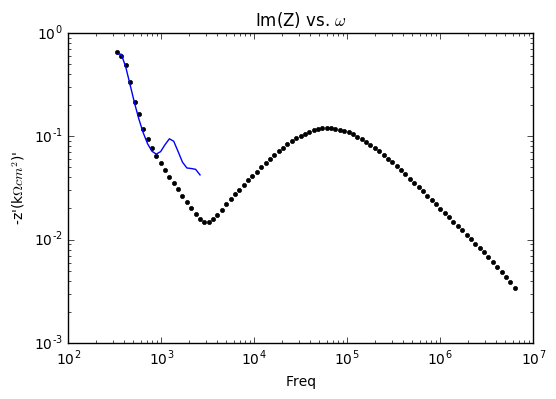

In [42]:
# run the fit to Im(z) vs. w

params = lmf.Parameters()  #add parameters with guesses
params.add('zd0',value = abs(Zi(12)[boundLF]), min = 0, max = 5)
params.add('td',value = 1e-4, min = 0, max = 1e-2)
params.add('b',value = 0.5 ,min = 0, max = 1)

fit = lmf.minimize(tFit1Resid,params,args = (w(12)[boundLF:boundHF],Zi(12)[boundLF:boundHF]))
zd0Fit = fit.params['zd0'].value
tdFit = fit.params['td'].value
betaFit = fit.params['b'].value
fit.params

print(fit.params)

# plot the resulting fit
fig,ax = plt.subplots(1,1)
ax.plot(w(12)[boundLF:],abs(Zi(12)[boundLF:]),'k.')                   

ax.plot(w(12)[boundLF:boundHF],-tFit1(w(12)[boundLF:boundHF],zd0Fit,tdFit,betaFit))
# ax.plot(zd0Fit*(np.tanh((1j*w(12)[boundLF:boundHF]*tdFit)**(betaFit))/((1j*w(12)[boundLF:boundHF]*tdFit)**(betaFit))))

ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")   
# ax.set_xlim([0,w(12)[boundHF]]);
                                   

Clearly, we need to play with the $\tau_{d}$ parameter. Perhaps this will be fixed with NLLS on each part...?

Let's try the total fit first, and then attempt to fit some low temperature data. If that doesn't work, then at least we have the kinetic part, which I'm certain we can then relate to Daniel's data.

In [38]:
# define functional forms for total fit to both the real and imaginary parts of Z

def circuitModelTot(w,Rs,Rct,z0,td,beta,alpha,Q):
    return Rs + ( ( (Rct + (z0*(np.tanh((1j*w*td)**beta)*(1j*w*td)**-beta))) * (1/((1j*w)**alpha)*Q) ) / ( (z0*(np.tanh((1j*w*td)**beta)*((1j*w*td)**beta)) ) + (1/((1j*w)**alpha)*Q)))     

def circuitResidTot(params,w,Zr,Zi):
    parvals = params.valuesdict()
    Rs = parvals['Rs']
    Rct = parvals['Rct']
    z0 = parvals['z0']
    td = parvals['td']
    beta = parvals['beta']
    alpha = parvals['alpha']
    Q = parvals['Q']
    
    ZrHat = np.real(circuitModelTot(w,Rs,Rct,z0,td,beta,alpha,Q)) 
    ZiHat = np.imag(circuitModelTot(w,Rs,Rct,z0,td,beta,alpha,Q)) 
    
    resid1 = ZrHat-Zr
    resid2 = ZiHat-Zi
    
    return np.concatenate((resid1,resid2))

def imCircuitModel(w,Rs,Rct,z0,td,beta,alpha,Q):
    return np.imag(Rs + ( ( (Rct + (z0*(np.tanh((1j*w*td)**-beta)*(1j*w*td)**beta))) * (1/((1j*w)**alpha)*Q) ) / ( (z0*(np.tanh((1j*w*td)**beta)*((1j*w*td)**-beta)) ) + (1/((1j*w)**alpha)*Q))))   

def reCircuitModel(w,Rs,Rct,z0,td,beta,alpha,Q):
    return np.real(Rs + ( ( (Rct + (z0*(np.tanh((1j*w*td)**-beta)*(1j*w*td)**beta))) * (1/((1j*w)**alpha)*Q) ) / ( (z0*(np.tanh((1j*w*td)**beta)*((1j*w*td)**-beta)) ) + (1/((1j*w)**alpha)*Q))))    


Parameters([('Rs', <Parameter 'Rs', value=0.5517723855968576 +/- 0, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=2.0285207896759774 +/- 0, bounds=[0:10]>), ('z0', <Parameter 'z0', value=7.667648653508774e-05 +/- 0, bounds=[0:5]>), ('td', <Parameter 'td', value=0.0099945211750910295 +/- 0, bounds=[0:0.01]>), ('beta', <Parameter 'beta', value=0.99834940711835429 +/- 0, bounds=[0:1]>), ('Q', <Parameter 'Q', value=0.001 +/- 0, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value=0.030019597214912375 +/- 0, bounds=[0:1]>)])


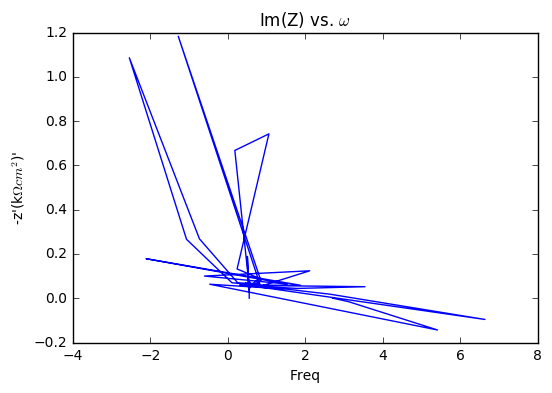

In [39]:
# run the total fit 

params = lmf.Parameters()  #add parameters with guesses
params.add('Rs',value = .002, min = 0, max = 5)
params.add('Rct',value = .266, min = 0, max = 10)

params.add('z0',value = abs(Zi(12)[boundLF]), min = 0, max = 5)
params.add('td',value = 1e-4, min = 0, max = 1e-2)
params.add('beta',value = 0.5, min = 0, max = 1)

params.add('Q',value = .001207, min = 0, max = 1e-3)
params.add('alpha',value = 0.93, min = 0, max = 1)

fit = lmf.minimize(circuitResidTot,params,args = (w(12)[boundLF:],Zr(12)[boundLF:],Zi(12)[boundLF:]))
RsFit = fit.params['Rs'].value
RctFit = fit.params['Rct'].value

z0Fit = fit.params['z0'].value
tdFit = fit.params['td'].value
betaFit = fit.params['beta'].value

Qfit = fit.params['Q'].value
alphaFit = fit.params['alpha'].value

fit.params
print(fit.params)

# plot the resulting fit
fig,ax = plt.subplots(1,1)
# ax.plot(Zr(12)[boundLF:],-Zi(12)[boundLF:],'k.')                    

ax.plot(np.real(circuitModelTot(w(12)[boundLF:],RsFit,RctFit,z0Fit,tdFit,betaFit,alphaFit,Qfit)),-np.imag(circuitModelTot(w(12)[boundLF:],RsFit,RctFit,z0Fit,tdFit,betaFit,alphaFit,Qfit)))

ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{2}$)'")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")   

In [32]:
print(w(12)[boundHF])

print(1/(w(12)[boundHF]))

2896.5
0.000345244260314
